## Import libraries

In [1]:
import os
import glob
import pickle
from pathlib import Path, PureWindowsPath

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower

from scipy import stats
from scipy.stats import gaussian_kde
from matplotlib.colors import to_rgba

## Config

In [2]:
class cfg:

    THIS_NOTEBOOK_ID: "FR_t01e01nb04v1"

    #=================================================
    ROOT_TRAINING_RSLTS = os.path.join('..', '..', '..',
                                       "results",
                                       "exp_track",
                                      )

## Utility functions

### flatten_dict()

In [3]:
def flatten_dict(d, parent_key='', sep='_'):
    """
    Description
    -----------
        Recursive, inspect inner dict and extract values

    Return: 
    ------
        flat_dictionary: It can be use as one row of a dataframe.
    """
    
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k

        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))

    return dict(items)

### perf_last_epoch_metric_distr_info()

In [4]:
def perf_last_epoch_metric_distr_info(d_meta, 
                                      arch_name_wild_card="resnet", 
                                      pipe_names=['pipe001']): 
    
    """
    Description:
    -----------
        Selecting and extracting performances on test for each fold, and then calculating
            distribution information "'mean', 'std', 'min', '25%', '50%', '75%', 'max'" 
            
    Parameters:
    -----------
        arch_name_wild_card: to select the architecture of interest
        pipe_names: list of preprocessing image pipeline id of interest

    Return: 
        d_m: dataframe organize to show for each training track id, the test performances across folds.

    """
    
    c1 = d_meta['architecture__arch_ID'].str.lower().str.contains(arch_name_wild_card)
    c2 = d_meta['prepro_pipe__pipe_name'].isin(pipe_names)
    
    d = d_meta[c1&c2].reset_index(drop=True)
    d
    
    
    #==========================================
    # Extracting performances, fold, leakage or not leakage
    track_slct_info = []
    for r, data in d.iterrows():
    
        #- - - - - - - - - - - - - - - - - 
        # Extracting information related to performance per epoch during training process. 
        fpath = data['path_perf_dct']
        with open(fpath, 'rb') as f:
            perf_dct = pickle.load(f)
            """
            perf_dct keys: 
                ['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 
                 'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 
                 'lr', 'track_train_id', 'fold_id', 'arch_id']
    
            """
            
        
    
        #- - - - - - - - - - - - - - - - - 
        track_slct_info.append([
            data['track_train_id'], 
            data['split_strategy__split_strategy_id'],
            data['training_step__training_strategy_id'],
            data['architecture__arch_ID'],
            data['fold_id'], 
            data['path_perf_dct'], 
            data['prepro_pipe__pipe_name'],
            data['split_strategy__shuffle_instances'], #True:leakage, False: 'no_leakage'
            data["training_step__epochs"],
            perf_dct['acc_tst'][-1], # last epoch performance
            perf_dct['ba_tst'][-1], # last epoch performance
            perf_dct['f1score_tst'][-1], # last epoch performance
            perf_dct['prcsn_tst'][-1], # last epoch performance
            perf_dct['rec_tst'][-1], # last epoch performance
        ])
    
        #_____________________________________
        # break
    #_________________________________________
    
    
    #===========================================================
    # Extracting test performance of last epoch of each fold. 
    cols = ['track_train_id', 'split_id', 'trn_strtgy_id', 'arch_name', 'fold_id', 'path_perf_dct', 'prepro_pipe__pipe_name', 
            'leakage', 'training_step__epochs', 'acc_tst', 'ba_tst', 'f1score_tst', 'prcsn_tst', 'rec_tst']
    d_m = pd.DataFrame(track_slct_info, columns=cols)
    d_m
    
    #===========================================================
    # Extracting summary (across fold) for same Track_ID
    metrics_dist_info = []
    for gr, data in d_m.groupby(['track_train_id', 'prepro_pipe__pipe_name', 'arch_name', 'split_id', 'trn_strtgy_id','leakage', 'training_step__epochs']): 
        #___________________________________________________
        # Calculating test metrics performance distribution info (last training epoch)
        cols = ['acc_tst', 'ba_tst', 'f1score_tst', 'prcsn_tst', 'rec_tst']
        d = data[cols].describe().T.reset_index().rename(columns={'index':'metrics'})
        
        #___________________________________________________
        # Adding meta info
        d[['track_train_id', 'pre_pipe_id', 'arch_name', 'split_id', 'trn_strtgy_id','leakage', 'n_epochs']] = gr
        
        #___________________________________________________
        # Reorganization of table
        cols = ['track_train_id', 'pre_pipe_id', 'arch_name', 'split_id', 'trn_strtgy_id','leakage', 'n_epochs', 
                'metrics', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max',]
        d = d[cols]
        d = d.rename(columns={'count':'fold_cnt'})
        
        #___________________________________________________
        # Store
        metrics_dist_info.append(d)
    
        #___________________________________________________
        # break
    #_______________________________________________________
    d_m = pd.concat(metrics_dist_info,  ignore_index=True)
    d_m = d_m.sort_values(by=['pre_pipe_id', 'arch_name', 'trn_strtgy_id',"track_train_id",'split_id', "leakage",], ignore_index=True)
    c1 = d_m["metrics"].isin(["acc_tst", "f1score_tst", "prcsn_tst", "rec_tst"])

    return d_m[c1]

### slctd_folds_perfrms()

In [5]:
def slctd_folds_perfrms(d_meta, split_ids, arch_ids, pipe_names): 

    """
    Descriptions:
    -------------
        This 

    """

    
    c1 = d_meta['architecture__arch_ID'].isin(arch_ids)
    c2 = d_meta['split_strategy__split_strategy_id'].isin(split_ids)
    c3 = d_meta['prepro_pipe__pipe_name'].isin(pipe_names)
    
    d = d_meta[c1&c2&c3].reset_index(drop=True)
    d
    
    #==========================================
    # Extracting performances, fold, leakage or not leakage
    track_slct_info = []
    for r, data in d.iterrows():
    
        #- - - - - - - - - - - - - - - - - 
        # Extracting information related to performance per epoch during training process. 
        fpath = data['path_perf_dct']
        with open(fpath, 'rb') as f:
            perf_dct = pickle.load(f)
            """
            perf_dct keys: 
                ['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 
                 'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 
                 'lr', 'track_train_id', 'fold_id', 'arch_id']
    
            """
            
        
    
        #- - - - - - - - - - - - - - - - - 
        track_slct_info.append([
            data['track_train_id'], 
            data['split_strategy__split_strategy_id'],
            data['training_step__training_strategy_id'],
            data['architecture__arch_ID'],
            int(perf_dct['fold_id'].split("_")[0][4:]),
            data['fold_id'], 
            data['path_perf_dct'], 
            data['prepro_pipe__pipe_name'],
            data['split_strategy__shuffle_instances'], #True:leakage, False: 'no_leakage'
            data["training_step__epochs"],
            perf_dct['acc_tst'][-1], # last epoch performance
            perf_dct['ba_tst'][-1], # last epoch performance
            perf_dct['f1score_tst'][-1], # last epoch performance
            perf_dct['prcsn_tst'][-1], # last epoch performance
            perf_dct['rec_tst'][-1], # last epoch performance
        ])
    
    #===========================================================
    # Extracting test performance of last epoch of each fold. 
    cols = ['track_train_id', 'split_id', 'trn_strtgy_id', 'arch_name', 'seed', 'fold_id', 'path_perf_dct', 'prepro_pipe__pipe_name', 
            'leakage', 'training_step__epochs', 'acc_tst', 'ba_tst', 'f1score_tst', 'prcsn_tst', 'rec_tst']
    d_m = pd.DataFrame(track_slct_info, columns=cols)
    #===========================================================
    return d_m

### Pandas Style: highlight_row_acc()

In [6]:
def highlight_row_acc(row):
    return ['background-color: #2a9d8f' if row['metrics']== 'acc_tst' else '' for _ in row]

## Extract performance during training epochs

In [7]:
#=====================================================================
# READ DATA
ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

model_epo_perf = glob.glob(os.path.join(ROOT_DATA, '*', 'perform_acrss_epo', "*", "performance_across_Epochs.pkl"))
model_epo_perf

#=====================================================================
# LOOP across each perforamnce directory
perf_meta = []
for p in model_epo_perf: 

    #_____________
    # Read file
    with open(p, 'rb') as f:
        perf_dct = pickle.load(f)

    #_____________
    # Extract keys
    trnTrackID = perf_dct['track_train_id']
    foldID = perf_dct['fold_id'] # nomenclature: f"seed{random_state in Kfold fun}_fold(n of data splits)
    archID = perf_dct['arch_id']

    perf_meta.append([trnTrackID, 
                      foldID, 
                      archID, 
                      p, 
                     ])

    #_________________________________________________
    # break
#=====================================================================
# Create metadatabase for perforamnces during training epochs during training.
cols = ['track_train_id', 'fold_id', 'arch_id', 'path_perf_dct']
d_prf_meta = pd.DataFrame(perf_meta, columns=cols)
d_prf_meta.head(3)

,track_train_id,fold_id,arch_id,path_perf_dct
0,TrainTrack_001,seed0_fold0,vanilla2DCNN_v1,../../../results/exp_track/TrainTrack_001/perf...
1,TrainTrack_001,seed0_fold1,vanilla2DCNN_v1,../../../results/exp_track/TrainTrack_001/perf...
2,TrainTrack_001,seed0_fold2,vanilla2DCNN_v1,../../../results/exp_track/TrainTrack_001/perf...


In [8]:
pickle_fpath = d_prf_meta["path_perf_dct"][0]
with open(pickle_fpath, 'rb') as f:
    perf_dct = pickle.load(f)

perf_dct.keys()

dict_keys(['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 'lr', 'track_train_id', 'fold_id', 'arch_id'])

**performance_across_Epochs.pkl:**
- For each epoch it calculates and stores performance metrics for training and test sets

## Extract Params for the whole DL pipeline

The deep learning (DL) pipeline will have different levels, depending on the step or phase of the process. For example, architectures may have different sets of parameters, and training strategies may vary as well.

I define unique DL pipeline stage IDs (e.g., raw data preprocessing, data split strategy, training strategy, architecture design) to make comparisons easier.

In [9]:
ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

ml_pipe_params_paths = glob.glob(os.path.join(ROOT_DATA, '*', 'ML_pipe_params', "ML_pipe_all_params_*.pkl"))
ml_pipe_params_paths

#=========================================================================
# LOOP across each perforamnce directory
ml_parms_meta = []
for p in ml_pipe_params_paths:

    #________________________
    # Read file 
    with open(p, 'rb') as f:
        ml_pipe_parms_dct = pickle.load(f)
    #________________________
    # Flat dictionary
    flat_dct = flatten_dict(ml_pipe_parms_dct, parent_key='', sep='__')

    
    #________________________
    # Store
    ml_parms_meta.append(flat_dct)

    #________________________
    # break
#----------------------------
# if a dictionary key is missing in some Training Track IDs, due to diff architecture, training, etc
#  -- it needs to be added with Nan values. <<--- Pending
d_ml_pipe_params = pd.DataFrame(ml_parms_meta)
d_ml_pipe_params.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   prepro_pipe__pipe_name                36 non-null     object 
 1   prepro_pipe__source_code              36 non-null     object 
 2   architecture__arch_ID                 36 non-null     object 
 3   architecture__params__in_channels     10 non-null     float64
 4   architecture__params__num_classes     36 non-null     int64  
 5   architecture__source_code             36 non-null     object 
 6   split_strategy__split_strategy_id     36 non-null     object 
 7   split_strategy__cv                    36 non-null     object 
 8   split_strategy__n_split               36 non-null     int64  
 9   split_strategy__cls_col               36 non-null     object 
 10  split_strategy__inst_n_order_col      36 non-null     object 
 11  split_strategy__shuff

## Extract prediction (y_pred per instance) of final training epoch

In [10]:
split_rslts = "test_result.csv" # last training epoch of that training track

ROOT_DATA = cfg.ROOT_TRAINING_RSLTS

ypred_rslts_paths = glob.glob(os.path.join(ROOT_DATA, "*", "predictions", "*", split_rslts,))
ypred_rslts_paths[:3]

['../../../results/exp_track/TrainTrack_001/predictions/seed0_fold0/test_result.csv',
 '../../../results/exp_track/TrainTrack_001/predictions/seed0_fold1/test_result.csv',
 '../../../results/exp_track/TrainTrack_001/predictions/seed0_fold2/test_result.csv']

## CREATE TRACK EXPERIMETS METADATA

**This DataFrame will contain all information related to:**
- Complete DL Pipelines hyperameters
- path to pickle file that contains the metric performance calculated during training epochs

In [11]:
d_meta = d_prf_meta.merge(d_ml_pipe_params,
                          how="left",
                          left_on="track_train_id",
                          right_on="training_step__TrackID")
d_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   track_train_id                        2160 non-null   object 
 1   fold_id                               2160 non-null   object 
 2   arch_id                               2160 non-null   object 
 3   path_perf_dct                         2160 non-null   object 
 4   prepro_pipe__pipe_name                2160 non-null   object 
 5   prepro_pipe__source_code              2160 non-null   object 
 6   architecture__arch_ID                 2160 non-null   object 
 7   architecture__params__in_channels     1040 non-null   float64
 8   architecture__params__num_classes     2160 non-null   int64  
 9   architecture__source_code             2160 non-null   object 
 10  split_strategy__split_strategy_id     2160 non-null   object 
 11  split_strategy__c

## VIZ Performances comparison

In [19]:
metric_tst = 'acc_tst' # option can be change for the keys read below
metric_trn = 'acc_trn' # option can be change for the keys read below
metric_loss_tst = 'loss_tst' # option can be change for the keys read below
metric_loss_trn = 'loss_trn' # option can be change for the keys read below
#==================================
metric_perf = []
for r, data in d_meta.iterrows():
    
    #---------------------------------------
    # Load performance during training epochs.
    performance_during_training_path = Path(PureWindowsPath(data["path_perf_dct"]))
    with open(performance_during_training_path, 'rb') as f:
        perf_dct = pickle.load(f)
        """
        Keys: 
            ['prcsn_trn', 'f1score_trn', 'rec_trn', 'ba_trn', 'acc_trn', 'loss_trn', 
             'prcsn_tst', 'f1score_tst', 'rec_tst', 'ba_tst', 'acc_tst', 'loss_tst', 
             'lr', 'track_train_id', 'fold_id', 'arch_id']

        """

    #---------------------------------------
    # Extracting metric performance selected during training epochs. 
    metric_perf.append((data["track_train_id"],
                        data["prepro_pipe__pipe_name"],
                        data["arch_id"],
                        perf_dct[metric_trn],
                        perf_dct[metric_tst],
                        perf_dct[metric_loss_tst],
                        perf_dct[metric_loss_trn],
                        data["split_strategy__shuffle_instances"]
                       ),
                       )

    #________________________________________________
    # break
#---------------------------------------------------
cols = ["track_train_id", "prepro_pipe__pipe_name","architecture__arch_ID",
        "metric_vals_trn","metric_vals_tst", "metric_vals_loss_trn","metric_vals_loss_tst", "leak"]
d_metric_perf = pd.DataFrame(metric_perf, columns=cols)
d_metric_perf.head(3)

,track_train_id,prepro_pipe__pipe_name,architecture__arch_ID,metric_vals_trn,metric_vals_tst,metric_vals_loss_trn,metric_vals_loss_tst,leak
0,TrainTrack_001,pipe001,vanilla2DCNN_v1,"[0.4178082191780822, 0.7100456621004566, 0.942...","[0.5384615384615384, 0.746606334841629, 0.9909...","[9.822555, 0.54832613, 0.03680376, 0.022098053...","[377.75214, 2.6491024, 0.18390802, 0.053121507...",True
1,TrainTrack_001,pipe001,vanilla2DCNN_v1,"[0.3701594533029613, 0.775626423690205, 0.9157...","[0.5570776255707762, 0.8264840182648402, 0.949...","[20.677664, 0.39223254, 0.17241229, 0.05959753...","[261.338, 3.0930045, 0.22288214, 0.07807572, 0...",True
2,TrainTrack_001,pipe001,vanilla2DCNN_v1,"[0.47038724373576307, 0.9009111617312073, 0.98...","[0.8036529680365296, 0.954337899543379, 0.9908...","[1.8257425, 0.16419002, 0.076046005, 0.0323798...","[283.84058, 1.1152544, 0.06775871, 0.021176891...",True


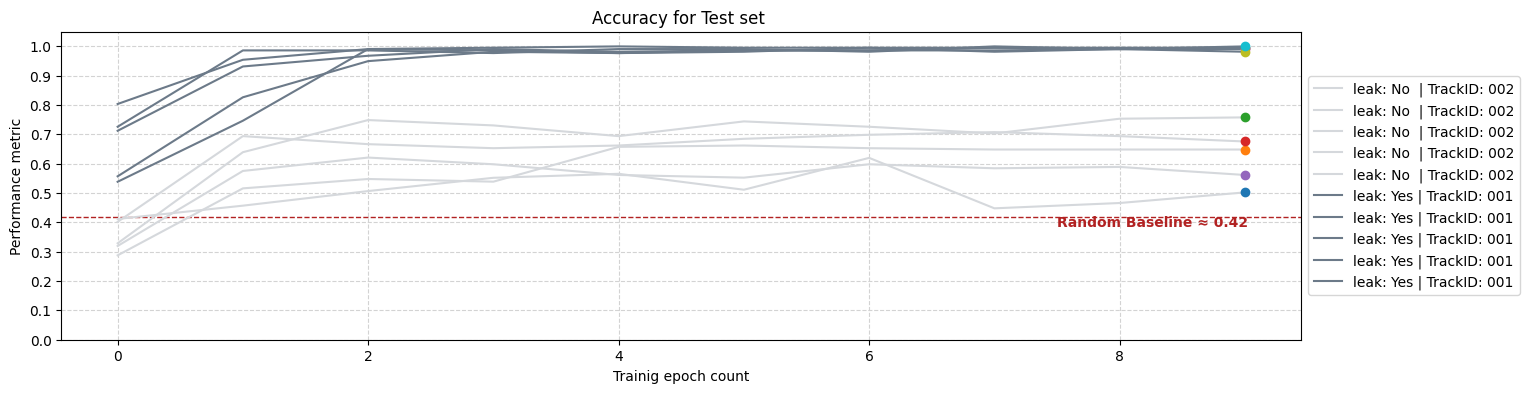

In [13]:

# arch_name_wild_card="alexnet"
# pipe_names = ["pipe001", "pipe002"]

arch_name_wild_card="vanilla"
pipe_names = ["pipe001"]#, "pipe002"]


#____
# Expected random accuracy for this unmbalance test set 
expected_random_accuracy = 0.4177023402469236
#____
c1 = d_metric_perf['architecture__arch_ID'].str.lower().str.contains(arch_name_wild_card)
c2 = d_metric_perf['prepro_pipe__pipe_name'].isin(pipe_names)

from matplotlib.lines import Line2D
custom_legend_handles1, custom_legend_handles2 = [], []
plt.figure(figsize=(16,4))
for r, data in d_metric_perf[c1&c2].sort_values(by=["leak"]).iterrows():

    #_______________________________________________________
    # Creating series label 
    leakage_exp = data["leak"]
    track = data["track_train_id"]
    
    leak = "Yes" if leakage_exp else "No "
    track = track.split("_")[1]
    serie_label_name = f"leak: {leak} | TrackID: {track}"

    #_______________________________________________________
    serie_values = data["metric_vals_tst"]

    #_______________________________________________________
    color_line = "#6C7A89" if leakage_exp else "#D5D8DC"
    plt.plot(serie_values, label=serie_label_name, color=color_line, zorder=3)

    # last epoch performace
    sc = plt.scatter(len(serie_values) - 1, serie_values[-1], zorder=3)
    #----------------------------

    legend_label = (
        f'{serie_label_name}: '
        f'$\u2015$'  # Unicode for horizontal line
        f' (line)  '
        f'$\u25CF$'  # Unicode for filled circle with this color : sc.get_facecolor()[0]
        f' (marker)' 
    )
    custom_legend_handles1.append(Line2D(
        [0], [0],
        color=color_line,
        # marker='o',
        # markerfacecolor=sc.get_facecolor()[0],
        # label=f'{serie_label_name}: line + marker'
        label=legend_label,
    ))

    #_______________________________________________________
    # break
#-----------------------------------------------------------
plt.axhline(expected_random_accuracy, color='firebrick', linestyle='--', linewidth=1, 
            # label='Random Baseline', 
           )
# Annotate the line
plt.text(
    x=7.5, 
    y=expected_random_accuracy - 0.03, 
    s=f'Random Baseline ≈ {expected_random_accuracy:.2f}',
    color='firebrick',
    fontsize=10,
    fontweight='bold'
)

plt.title("Accuracy for Test set ")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(color='lightgray', linestyle="--", zorder=0 )
plt.yticks(np.arange(0, 1.1, 0.1)) 
plt.ylabel("Performance metric")
plt.xlabel("Trainig epoch count")
plt.ylim(0,1.05)
plt.show()

,track_train_id,prepro_pipe__pipe_name,architecture__arch_ID,metric_vals_trn,metric_vals_tst,metric_vals_loss_trn,metric_vals_loss_tst,leak
0,TrainTrack_001,pipe001,vanilla2DCNN_v1,"[0.4178082191780822, 0.7100456621004566, 0.942...","[0.5384615384615384, 0.746606334841629, 0.9909...","[9.822555, 0.54832613, 0.03680376, 0.022098053...","[377.75214, 2.6491024, 0.18390802, 0.053121507...",True
1,TrainTrack_001,pipe001,vanilla2DCNN_v1,"[0.3701594533029613, 0.775626423690205, 0.9157...","[0.5570776255707762, 0.8264840182648402, 0.949...","[20.677664, 0.39223254, 0.17241229, 0.05959753...","[261.338, 3.0930045, 0.22288214, 0.07807572, 0...",True
2,TrainTrack_001,pipe001,vanilla2DCNN_v1,"[0.47038724373576307, 0.9009111617312073, 0.98...","[0.8036529680365296, 0.954337899543379, 0.9908...","[1.8257425, 0.16419002, 0.076046005, 0.0323798...","[283.84058, 1.1152544, 0.06775871, 0.021176891...",True
3,TrainTrack_001,pipe001,vanilla2DCNN_v1,"[0.44760820045558086, 0.835990888382688, 0.979...","[0.7123287671232876, 0.9315068493150684, 0.968...","[1.5545843, 0.21716727, 0.08946677, 0.05470449...","[192.34941, 0.5263077, 0.11201974, 0.02263636,...",True
4,TrainTrack_001,pipe001,vanilla2DCNN_v1,"[0.4521640091116173, 0.8895216400911162, 0.982...","[0.726027397260274, 0.9863013698630136, 0.9863...","[1.9050288, 0.053114805, 0.034353122, 0.047133...","[244.3109, 0.4557188, 0.05011402, 0.02848295, ...",True
...,...,...,...,...,...,...,...,...
1155,TrainTrack_034,pipe003,vanilla2DCNN_v1,"[0.4429223744292237, 0.7077625570776256, 0.892...","[0.20361990950226244, 0.4751131221719457, 0.86...","[1.186445, 0.9132548, 0.5141538, 0.77292204, 0...","[1.5774424, 0.7803203, 0.36061794, 0.108108476...",False
1156,TrainTrack_034,pipe003,vanilla2DCNN_v1,"[0.5170842824601367, 0.7687927107061503, 0.922...","[0.6164383561643836, 0.5616438356164384, 0.757...","[1.0262756, 0.9541572, 0.6708604, 0.85630584, ...","[1.6392424, 0.66021955, 0.2961455, 0.11607806,...",False
1157,TrainTrack_034,pipe003,vanilla2DCNN_v1,"[0.38496583143507973, 0.7380410022779044, 0.86...","[0.5662100456621004, 0.684931506849315, 0.6803...","[0.9668568, 0.7711417, 0.8493727, 0.96205115, ...","[2.3368206, 0.77927834, 0.4103617, 0.18705541,...",False
1158,TrainTrack_034,pipe003,vanilla2DCNN_v1,"[0.3815489749430524, 0.6150341685649203, 0.760...","[0.3789954337899543, 0.4611872146118721, 0.543...","[1.1159933, 1.1825168, 1.1741986, 0.99346584, ...","[2.567968, 0.9561488, 0.61904407, 0.2994954, 0...",False


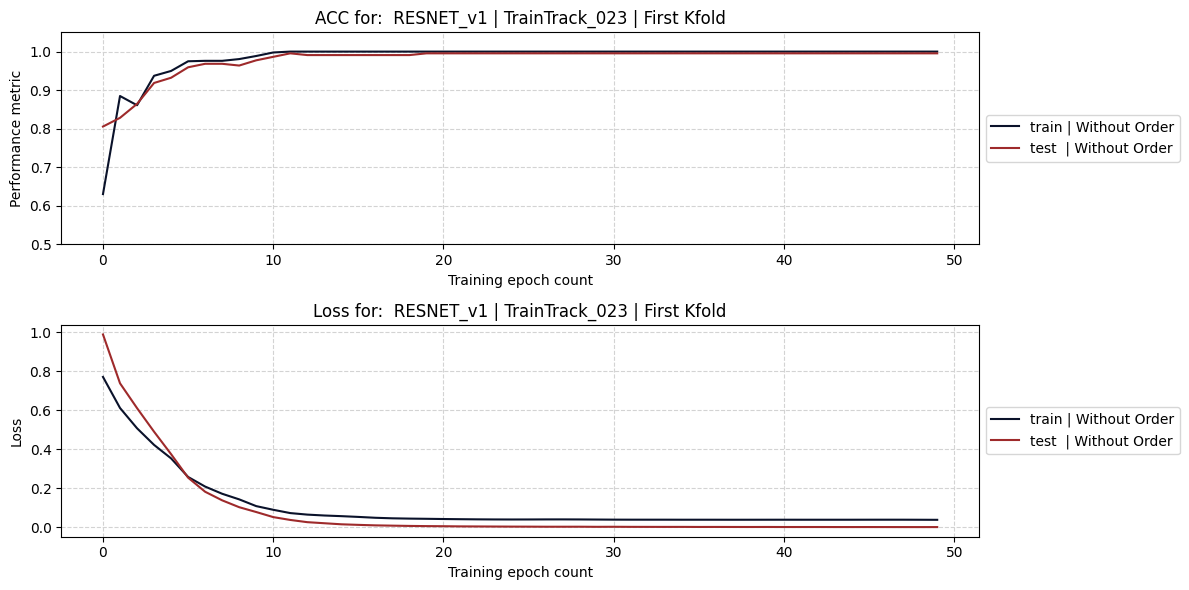

In [26]:
architecture__arch_ID = 'RESNET_v1'
track_train_id = "TrainTrack_023" # RESNET without order consideration (leakage)
leak = True
fold_id = 0

#================================================================
c1 = d_metric_perf.architecture__arch_ID == architecture__arch_ID
c2 = d_metric_perf.track_train_id == track_train_id
c3 = d_metric_perf.leak == leak
d = d_metric_perf[c1&c2&c3].reset_index(drop=True)

trn = d.iloc[fold_id,:].metric_vals_trn
tst = d.iloc[fold_id,:].metric_vals_tst

loss_trn = d.iloc[fold_id,:].metric_vals_loss_trn
loss_tst = d.iloc[fold_id,:].metric_vals_loss_tst

#================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(trn, label="train | Without Order", color="#0A122A", zorder=3)
ax1.plot(tst, label="test  | Without Order", color="#9E2A2B", zorder=3)

ax1.set_title(f"ACC for:  {architecture__arch_ID} | {track_train_id} | First Kfold")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Corrected from set_legend
ax1.grid(color='lightgray', linestyle="--", zorder=0)
ax1.set_yticks(np.arange(0, 1.1, 0.1)) 
ax1.set_ylabel("Performance metric")
ax1.set_xlabel("Training epoch count")  # Fixed typo
ax1.set_ylim(0.5, 1.05)

#==========
ax2.plot(loss_trn, label="train | Without Order", color="#0A122A", zorder=3)
ax2.plot(loss_tst, label="test  | Without Order", color="#9E2A2B", zorder=3)

ax2.set_title(f"Loss for:  {architecture__arch_ID} | {track_train_id} | First Kfold")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Corrected from set_legend
ax2.grid(color='lightgray', linestyle="--", zorder=0)
# ax2.set_yticks(np.arange(0, 1.1, 0.1)) 
ax2.set_ylabel("Loss")
ax2.set_xlabel("Training epoch count")  # Fixed typo


plt.tight_layout()
plt.show()

**Loss in inference does not have class balance approach during within loss function**

In [48]:
c = d_metric_perf.architecture__arch_ID ==  "vanilla2DCNN_v1"
d_metric_perf[c].track_train_id.unique()

array(['TrainTrack_001', 'TrainTrack_002', 'TrainTrack_011',
       'TrainTrack_012', 'TrainTrack_019', 'TrainTrack_020',
       'TrainTrack_021', 'TrainTrack_022', 'TrainTrack_033',
       'TrainTrack_034'], dtype=object)

In [56]:
c = d_metric_perf["track_train_id"] == 'TrainTrack_021'
d_metric_perf[c]

,track_train_id,prepro_pipe__pipe_name,architecture__arch_ID,metric_vals_trn,metric_vals_tst,metric_vals_loss_trn,metric_vals_loss_tst,leak
100,TrainTrack_021,pipe004,vanilla2DCNN_v1,"[0.4417808219178082, 0.7363013698630136, 0.833...","[0.7194570135746606, 0.5972850678733032, 0.868...","[0.8995429, 0.6993238, 0.3429875, 0.24748263, ...","[2.052464, 0.7566124, 0.453373, 0.2804565, 0.2...",True
101,TrainTrack_021,pipe004,vanilla2DCNN_v1,"[0.43735763097949887, 0.7357630979498861, 0.90...","[0.547945205479452, 0.8767123287671232, 0.8949...","[0.89596933, 0.4044041, 0.27864513, 0.20881939...","[2.1334746, 0.7539694, 0.32223973, 0.16749759,...",True
102,TrainTrack_021,pipe004,vanilla2DCNN_v1,"[0.33712984054669703, 0.7949886104783599, 0.93...","[0.730593607305936, 0.9178082191780822, 0.9543...","[0.87475145, 0.34128058, 0.15464772, 0.1535154...","[2.1655712, 0.690195, 0.2828199, 0.1349299, 0....",True
103,TrainTrack_021,pipe004,vanilla2DCNN_v1,"[0.37813211845102507, 0.6879271070615034, 0.91...","[0.3287671232876712, 0.821917808219178, 0.9223...","[1.0650213, 0.47994873, 0.22337942, 0.11666765...","[3.0850093, 0.7410942, 0.32626235, 0.1579431, ...",True
104,TrainTrack_021,pipe004,vanilla2DCNN_v1,"[0.5375854214123007, 0.8895216400911162, 0.952...","[0.6575342465753424, 0.8036529680365296, 0.990...","[0.72409415, 0.34172744, 0.11971362, 0.0778252...","[1.2398039, 0.42557958, 0.17880426, 0.08125934...",True


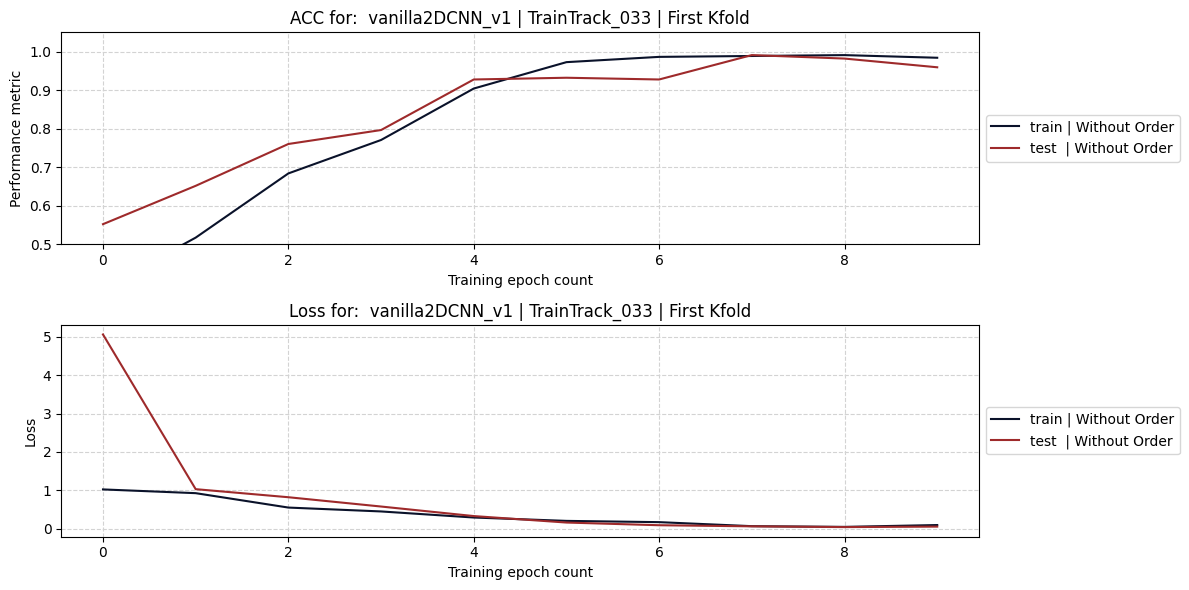

In [59]:
architecture__arch_ID = 'vanilla2DCNN_v1'
track_train_id = "TrainTrack_033" # RESNET without order consideration (leakage)
leak = True
fold_id = 0

#================================================================
c1 = d_metric_perf.architecture__arch_ID == architecture__arch_ID
c2 = d_metric_perf.track_train_id == track_train_id
c3 = d_metric_perf.leak == leak
d = d_metric_perf[c1&c2&c3].reset_index(drop=True)

trn = d.iloc[fold_id,:].metric_vals_trn
tst = d.iloc[fold_id,:].metric_vals_tst

loss_trn = d.iloc[fold_id,:].metric_vals_loss_trn
loss_tst = d.iloc[fold_id,:].metric_vals_loss_tst

#================================================================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(trn, label="train | Without Order", color="#0A122A", zorder=3)
ax1.plot(tst, label="test  | Without Order", color="#9E2A2B", zorder=3)

ax1.set_title(f"ACC for:  {architecture__arch_ID} | {track_train_id} | First Kfold")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Corrected from set_legend
ax1.grid(color='lightgray', linestyle="--", zorder=0)
ax1.set_yticks(np.arange(0, 1.1, 0.1)) 
ax1.set_ylabel("Performance metric")
ax1.set_xlabel("Training epoch count")  # Fixed typo
ax1.set_ylim(0.5, 1.05)

#==========
ax2.plot(loss_trn, label="train | Without Order", color="#0A122A", zorder=3)
ax2.plot(loss_tst, label="test  | Without Order", color="#9E2A2B", zorder=3)

ax2.set_title(f"Loss for:  {architecture__arch_ID} | {track_train_id} | First Kfold")
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Corrected from set_legend
ax2.grid(color='lightgray', linestyle="--", zorder=0)
# ax2.set_yticks(np.arange(0, 1.1, 0.1)) 
ax2.set_ylabel("Loss")
ax2.set_xlabel("Training epoch count")  # Fixed typo


plt.tight_layout()
plt.show()

In [55]:
d

,track_train_id,prepro_pipe__pipe_name,architecture__arch_ID,metric_vals_trn,metric_vals_tst,metric_vals_loss_trn,metric_vals_loss_tst,leak


# Tracking DL pipeline hyperameters

## Split strategy | without track seed.

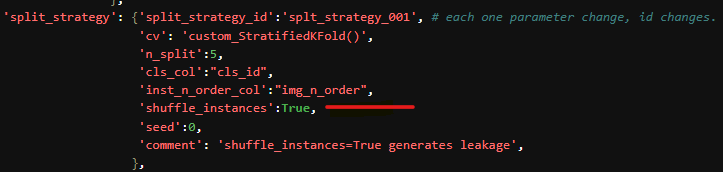

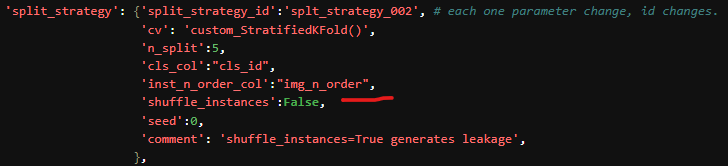

## Training Strategy params

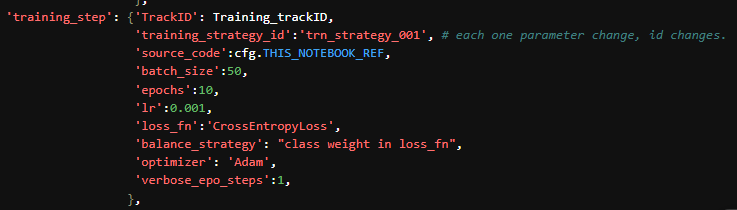

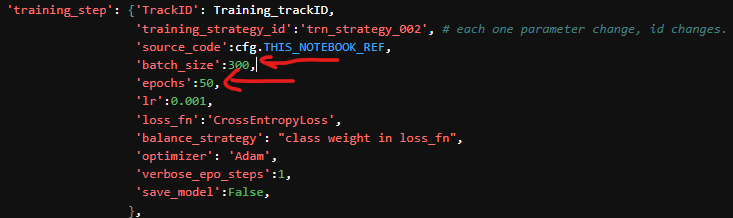

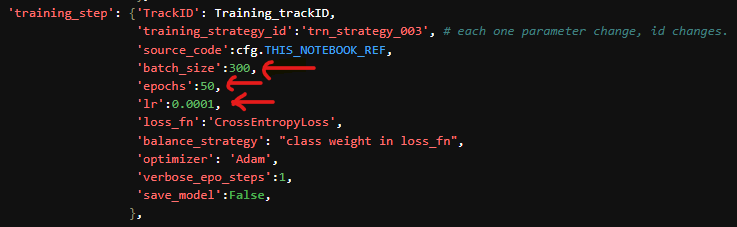

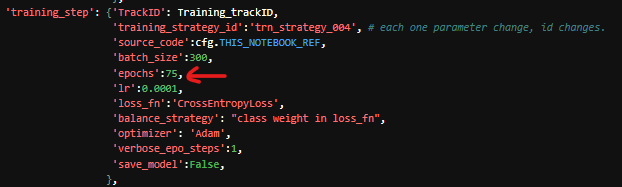

# REPORT - EXPLORATION

## Vanilla CNN | Pipe001

In [14]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="vanilla", 
                                        pipe_names=['pipe001'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.000000,0.992702,0.006929,0.981735,0.990868,0.995434,0.995475,1.000000
2,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.000000,0.987748,0.012374,0.969210,0.982095,0.990935,0.996498,1.000000
3,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.000000,0.989950,0.011052,0.974525,0.982095,0.996078,0.997050,1.000000
4,TrainTrack_001,pipe001,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.000000,0.985676,0.014019,0.964190,0.982095,0.986111,0.995984,1.000000
5,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.000000,0.629220,0.099755,0.502262,0.561644,0.648402,0.675799,0.757991
7,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.000000,0.565264,0.104724,0.480887,0.487167,0.499236,0.669946,0.689086
8,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.000000,0.659786,0.067995,0.572511,0.601160,0.694097,0.711334,0.719826
9,TrainTrack_002,pipe001,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.000000,0.560157,0.116979,0.454951,0.468921,0.503717,0.677006,0.696190


## Vanilla CNN | Pipe002

In [15]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="vanilla", 
                                        pipe_names=['pipe002'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_011,pipe002,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.000000,0.951673,0.026768,0.904110,0.959276,0.963470,0.963470,0.968037
2,TrainTrack_011,pipe002,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.000000,0.932154,0.042254,0.857441,0.939935,0.952723,0.954618,0.956054
3,TrainTrack_011,pipe002,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.000000,0.947735,0.028792,0.897965,0.951263,0.955975,0.962466,0.971005
4,TrainTrack_011,pipe002,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.000000,0.921097,0.051287,0.832007,0.926640,0.941373,0.944349,0.961118
5,TrainTrack_012,pipe002,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.000000,0.739540,0.108592,0.601810,0.680365,0.721461,0.821918,0.872146
7,TrainTrack_012,pipe002,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.000000,0.655790,0.078759,0.521321,0.650880,0.691857,0.701611,0.713283
8,TrainTrack_012,pipe002,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.000000,0.727055,0.137879,0.528533,0.696506,0.748052,0.748598,0.913584
9,TrainTrack_012,pipe002,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.000000,0.666580,0.096106,0.520842,0.638124,0.691134,0.702046,0.780754


## Vanilla CNN | Pipe003

In [16]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="vanilla", 
                                        pipe_names=['pipe003'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_019,pipe003,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.000000,0.996355,0.005952,0.986301,0.995475,1.000000,1.000000,1.000000
2,TrainTrack_019,pipe003,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.000000,0.992734,0.011849,0.972735,0.990935,1.000000,1.000000,1.000000
3,TrainTrack_019,pipe003,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.000000,0.994730,0.009741,0.977571,0.996078,1.000000,1.000000,1.000000
4,TrainTrack_019,pipe003,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.000000,0.990863,0.014021,0.968206,0.986111,1.000000,1.000000,1.000000
5,TrainTrack_020,pipe003,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.000000,0.805145,0.090079,0.683258,0.735160,0.858447,0.863014,0.885845
7,TrainTrack_020,pipe003,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.000000,0.706359,0.104630,0.581600,0.629224,0.709025,0.771174,0.840773
8,TrainTrack_020,pipe003,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.000000,0.772107,0.111897,0.630853,0.696529,0.791125,0.823623,0.918406
9,TrainTrack_020,pipe003,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.000000,0.733204,0.102566,0.636654,0.667790,0.703182,0.761570,0.896825
10,TrainTrack_033,pipe003,vanilla2DCNN_v1,splt_strategy_003,trn_strategy_001,True,10,acc_tst,500.000000,0.986489,0.014531,0.748858,0.981735,0.990868,0.995434,1.000000
12,TrainTrack_033,pipe003,vanilla2DCNN_v1,splt_strategy_003,trn_strategy_001,True,10,f1score_tst,500.000000,0.977299,0.021548,0.668552,0.969210,0.981539,0.990912,1.000000


## Vanilla CNN | Pipe004

In [17]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="vanilla", 
                                        pipe_names=['pipe004'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_021,pipe004,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.000000,0.992711,0.005199,0.986301,0.990868,0.990950,0.995434,1.000000
2,TrainTrack_021,pipe004,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.000000,0.987685,0.011141,0.972328,0.982095,0.987505,0.996498,1.000000
3,TrainTrack_021,pipe004,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.000000,0.992120,0.006989,0.982095,0.989207,0.992248,0.997050,1.000000
4,TrainTrack_021,pipe004,vanilla2DCNN_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.000000,0.983915,0.016299,0.958333,0.982095,0.983161,0.995984,1.000000
5,TrainTrack_022,pipe004,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.000000,0.796934,0.081350,0.678733,0.762557,0.799087,0.872146,0.872146
7,TrainTrack_022,pipe004,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.000000,0.695478,0.097006,0.604666,0.654052,0.666427,0.692976,0.859269
8,TrainTrack_022,pipe004,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.000000,0.706461,0.096365,0.602390,0.655853,0.662770,0.772722,0.838571
9,TrainTrack_022,pipe004,vanilla2DCNN_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.000000,0.713268,0.116452,0.624666,0.655455,0.679456,0.690094,0.916667


## RESNET | PIPE001

In [18]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="resnet", 
                                        pipe_names=['pipe001'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.000000,0.446637,0.054383,0.351598,0.456621,0.466063,0.470320,0.488584
2,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.000000,0.373715,0.060990,0.286788,0.348071,0.375259,0.413433,0.445026
3,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.000000,0.379207,0.049016,0.313420,0.350830,0.382876,0.410870,0.438038
4,TrainTrack_003,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.000000,0.381366,0.068531,0.291535,0.349601,0.372514,0.422918,0.470262
5,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.000000,0.367351,0.017394,0.347032,0.351598,0.374429,0.375566,0.388128
7,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.000000,0.302172,0.031685,0.265009,0.270486,0.319338,0.327559,0.328469
8,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.000000,0.348270,0.063175,0.277884,0.314719,0.349710,0.351405,0.447630
9,TrainTrack_004,pipe001,RESNET_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.000000,0.321914,0.032517,0.280240,0.302878,0.319901,0.344354,0.362199
10,TrainTrack_005,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_002,True,50,acc_tst,5.000000,0.963495,0.023314,0.931507,0.954338,0.958904,0.986301,0.986425
12,TrainTrack_005,pipe001,RESNET_v1,splt_strategy_001,trn_strategy_002,True,50,f1score_tst,5.000000,0.939485,0.036484,0.890557,0.925640,0.929781,0.972735,0.978712


**TrainTrack 004 and 003**
- A clear example showing that a poorly configured algorithm can perform worse than simpler algorithms (e.g., vanilla 2D CNN), even when those simpler models suffer from data leakage.


**TrainTrack 005 and 006:**

Only Training step strategy was updated. 
- Pipe001 outputs images with raw pixel values. Even though ResNet includes batch normalization layers, small batch sizes are likely to cause instability.
- Larger batch sizes and more training epochs were used to improve stability, with the expectation of achieving over 90% accuracy with leakage, and close to 70% without leakage.

## RESNET | PIPE002

In [19]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="resnet", 
                                        pipe_names=['pipe002'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_013,pipe002,RESNET_v1,splt_strategy_001,trn_strategy_002,True,50,acc_tst,5.000000,0.951763,0.028682,0.909502,0.945205,0.949772,0.968037,0.986301
2,TrainTrack_013,pipe002,RESNET_v1,splt_strategy_001,trn_strategy_002,True,50,f1score_tst,5.000000,0.921126,0.045484,0.858105,0.908230,0.912569,0.947614,0.979111
3,TrainTrack_013,pipe002,RESNET_v1,splt_strategy_001,trn_strategy_002,True,50,prcsn_tst,5.000000,0.907619,0.047201,0.841667,0.896813,0.900206,0.929114,0.970294
4,TrainTrack_013,pipe002,RESNET_v1,splt_strategy_001,trn_strategy_002,True,50,rec_tst,5.000000,0.939900,0.041817,0.885026,0.923229,0.928285,0.973967,0.988992
5,TrainTrack_014,pipe002,RESNET_v1,splt_strategy_002,trn_strategy_002,False,50,acc_tst,5.000000,0.715449,0.078394,0.602740,0.671233,0.735160,0.776256,0.791855
7,TrainTrack_014,pipe002,RESNET_v1,splt_strategy_002,trn_strategy_002,False,50,f1score_tst,5.000000,0.610864,0.073227,0.503930,0.569410,0.638327,0.660606,0.682045
8,TrainTrack_014,pipe002,RESNET_v1,splt_strategy_002,trn_strategy_002,False,50,prcsn_tst,5.000000,0.616491,0.060345,0.531551,0.578447,0.643268,0.647875,0.681314
9,TrainTrack_014,pipe002,RESNET_v1,splt_strategy_002,trn_strategy_002,False,50,rec_tst,5.000000,0.622679,0.080829,0.512395,0.569612,0.638889,0.690464,0.702034
10,TrainTrack_015,pipe002,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,acc_tst,5.000000,0.993616,0.004089,0.986301,0.995434,0.995434,0.995434,0.995475
12,TrainTrack_015,pipe002,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,f1score_tst,5.000000,0.988326,0.009500,0.971861,0.990912,0.990935,0.991426,0.996498


## RESNET | PIPE003

In [20]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="resnet", 
                                        pipe_names=['pipe003'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_023,pipe003,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,acc_tst,5.000000,0.991789,0.005960,0.981735,0.990868,0.995434,0.995434,0.995475
2,TrainTrack_023,pipe003,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,f1score_tst,5.000000,0.984451,0.013738,0.961854,0.981539,0.990935,0.991426,0.996498
3,TrainTrack_023,pipe003,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,prcsn_tst,5.000000,0.993402,0.005280,0.984674,0.992157,0.996078,0.997050,0.997050
4,TrainTrack_023,pipe003,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,rec_tst,5.000000,0.976975,0.020057,0.944444,0.972222,0.986111,0.986111,0.995984
5,TrainTrack_024,pipe003,RESNET_v1,splt_strategy_002,trn_strategy_003,False,50,acc_tst,5.000000,0.871514,0.053898,0.817352,0.835616,0.846154,0.922374,0.936073
7,TrainTrack_024,pipe003,RESNET_v1,splt_strategy_002,trn_strategy_003,False,50,f1score_tst,5.000000,0.750019,0.121062,0.651462,0.657558,0.676826,0.875034,0.889216
8,TrainTrack_024,pipe003,RESNET_v1,splt_strategy_002,trn_strategy_003,False,50,prcsn_tst,5.000000,0.756031,0.115124,0.668327,0.668447,0.679492,0.875438,0.888450
9,TrainTrack_024,pipe003,RESNET_v1,splt_strategy_002,trn_strategy_003,False,50,rec_tst,5.000000,0.752104,0.121561,0.656459,0.657965,0.676587,0.874665,0.894841
10,TrainTrack_035,pipe003,RESNET_v1,splt_strategy_004,trn_strategy_003,False,50,acc_tst,500.000000,0.859791,0.048168,0.703196,0.826484,0.858447,0.890411,0.986301
12,TrainTrack_035,pipe003,RESNET_v1,splt_strategy_004,trn_strategy_003,False,50,f1score_tst,500.000000,0.729572,0.089383,0.563540,0.657412,0.718170,0.787954,0.971861


## RESNET | PIPE004

In [21]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="resnet", 
                                        pipe_names=['pipe004'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_025,pipe004,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,acc_tst,5.000000,0.970818,0.018169,0.945205,0.968037,0.968037,0.977376,0.995434
2,TrainTrack_025,pipe004,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,f1score_tst,5.000000,0.943661,0.034094,0.899025,0.929980,0.939805,0.958582,0.990912
3,TrainTrack_025,pipe004,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,prcsn_tst,5.000000,0.966023,0.030123,0.917033,0.961200,0.974578,0.981273,0.996032
4,TrainTrack_025,pipe004,RESNET_v1,splt_strategy_001,trn_strategy_003,True,50,rec_tst,5.000000,0.928161,0.038430,0.886857,0.902778,0.923563,0.941495,0.986111
5,TrainTrack_026,pipe004,RESNET_v1,splt_strategy_002,trn_strategy_003,False,50,acc_tst,5.000000,0.852352,0.069959,0.776256,0.799087,0.837104,0.913242,0.936073
7,TrainTrack_026,pipe004,RESNET_v1,splt_strategy_002,trn_strategy_003,False,50,f1score_tst,5.000000,0.709478,0.149540,0.553503,0.623478,0.630649,0.864725,0.875034
8,TrainTrack_026,pipe004,RESNET_v1,splt_strategy_002,trn_strategy_003,False,50,prcsn_tst,5.000000,0.708356,0.153180,0.542206,0.627451,0.628778,0.867905,0.875438
9,TrainTrack_026,pipe004,RESNET_v1,splt_strategy_002,trn_strategy_003,False,50,rec_tst,5.000000,0.715273,0.144779,0.566265,0.629482,0.638889,0.867063,0.874665


## ALEXNET | PIPE001

In [22]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="alexnet", 
                                        pipe_names=['pipe001'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,acc_tst,5.000000,0.432873,0.181139,0.109589,0.502262,0.506849,0.511416,0.534247
2,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,f1score_tst,5.000000,0.270114,0.127761,0.065844,0.225579,0.335280,0.346542,0.377323
3,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,prcsn_tst,5.000000,0.279592,0.175575,0.036530,0.170472,0.333088,0.379687,0.478185
4,TrainTrack_007,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_001,True,10,rec_tst,5.000000,0.371819,0.040988,0.333333,0.333333,0.363078,0.412686,0.416667
5,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,acc_tst,5.000000,0.280076,0.135263,0.109589,0.158371,0.356164,0.378995,0.397260
7,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,f1score_tst,5.000000,0.215405,0.125336,0.065844,0.139687,0.183223,0.327476,0.360797
8,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,prcsn_tst,5.000000,0.285231,0.189621,0.036530,0.126332,0.400416,0.412698,0.450177
9,TrainTrack_008,pipe001,ALEXNET_v1,splt_strategy_002,trn_strategy_001,False,10,rec_tst,5.000000,0.368304,0.042815,0.333333,0.333333,0.356879,0.382100,0.435874
10,TrainTrack_009,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_003,True,50,acc_tst,5.000000,0.971723,0.008219,0.963470,0.963470,0.972603,0.977169,0.981900
12,TrainTrack_009,pipe001,ALEXNET_v1,splt_strategy_001,trn_strategy_003,True,50,f1score_tst,5.000000,0.963092,0.011786,0.943337,0.963740,0.966140,0.967464,0.974779


**AlexNet**
- user larger kernel size in the first 2D CNN layers compared to Vanilla2DCNN and RESNET18. Therefore, initially is very sensitive to inputs (img) scales and gradients.
- Has no mechanism to normalize internal activations, so it's vulnerable to high variance in gradients
    - AlexNet’s early layers can produce very large activations, especially with unnormalized inputs (pixel values 0–255)
- Small batches gradient estimtes are more noisy, each mini-batch gives a slightly different direction for optimization
- so, smaller lr control activation, larger batch less noisy gradients estimates creating, helping to reach estability faster, but to be sure, increase number of training epochs. 

In [23]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="alexnet", 
                                        pipe_names=['pipe002'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_027,pipe002,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,acc_tst,5.000000,0.923304,0.118443,0.712329,0.963470,0.968037,0.981735,0.990950
2,TrainTrack_027,pipe002,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,f1score_tst,5.000000,0.896063,0.150292,0.629676,0.933901,0.954708,0.974525,0.987505
3,TrainTrack_027,pipe002,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,prcsn_tst,5.000000,0.922488,0.116271,0.716923,0.946340,0.970807,0.986120,0.992248
4,TrainTrack_027,pipe002,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,rec_tst,5.000000,0.908114,0.108981,0.719449,0.909674,0.964094,0.964190,0.983161
5,TrainTrack_028,pipe002,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,acc_tst,5.000000,0.729280,0.096230,0.566210,0.719457,0.771689,0.789954,0.799087
7,TrainTrack_028,pipe002,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,f1score_tst,5.000000,0.636076,0.129627,0.451096,0.609015,0.626148,0.685705,0.808417
8,TrainTrack_028,pipe002,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,prcsn_tst,5.000000,0.640130,0.130176,0.456614,0.615616,0.626916,0.684209,0.817293
9,TrainTrack_028,pipe002,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,rec_tst,5.000000,0.648432,0.148453,0.450134,0.615606,0.625837,0.688528,0.862055


In [24]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="alexnet", 
                                        pipe_names=['pipe003'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_029,pipe003,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,acc_tst,5.000000,0.914263,0.030646,0.867580,0.899543,0.926941,0.936073,0.941176
2,TrainTrack_029,pipe003,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,f1score_tst,5.000000,0.866539,0.039827,0.814346,0.833333,0.887974,0.895985,0.901058
3,TrainTrack_029,pipe003,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,prcsn_tst,5.000000,0.867723,0.043974,0.815173,0.831164,0.872180,0.905943,0.914158
4,TrainTrack_029,pipe003,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,rec_tst,5.000000,0.879640,0.035604,0.835784,0.854956,0.884060,0.896491,0.926910
5,TrainTrack_030,pipe003,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,acc_tst,5.000000,0.752152,0.078898,0.652968,0.696833,0.767123,0.789954,0.853881
7,TrainTrack_030,pipe003,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,f1score_tst,5.000000,0.638708,0.100230,0.527423,0.583688,0.592357,0.742471,0.747598
8,TrainTrack_030,pipe003,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,prcsn_tst,5.000000,0.646975,0.102426,0.534085,0.583332,0.607986,0.740157,0.769315
9,TrainTrack_030,pipe003,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,rec_tst,5.000000,0.662273,0.127985,0.538380,0.585258,0.595010,0.753012,0.839704


In [25]:
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card="alexnet", 
                                        pipe_names=['pipe004'])
d_m.style.apply(highlight_row_acc, axis=1)

,track_train_id,pre_pipe_id,arch_name,split_id,trn_strtgy_id,leakage,n_epochs,metrics,fold_cnt,mean,std,min,25%,50%,75%,max
0,TrainTrack_031,pipe004,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,acc_tst,5.000000,0.930693,0.012815,0.917808,0.917808,0.931507,0.940639,0.945701
2,TrainTrack_031,pipe004,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,f1score_tst,5.000000,0.864150,0.034434,0.810119,0.854935,0.872345,0.882846,0.900507
3,TrainTrack_031,pipe004,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,prcsn_tst,5.000000,0.878529,0.026627,0.851654,0.856652,0.871997,0.900507,0.911836
4,TrainTrack_031,pipe004,ALEXNET_v1,splt_strategy_001,trn_strategy_004,True,75,rec_tst,5.000000,0.858332,0.039426,0.793651,0.859641,0.865132,0.872729,0.900507
5,TrainTrack_032,pipe004,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,acc_tst,5.000000,0.765817,0.091957,0.657534,0.714932,0.767123,0.785388,0.904110
7,TrainTrack_032,pipe004,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,f1score_tst,5.000000,0.656601,0.129456,0.525229,0.579469,0.612294,0.712624,0.853389
8,TrainTrack_032,pipe004,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,prcsn_tst,5.000000,0.654849,0.120466,0.526566,0.585005,0.618528,0.709180,0.834967
9,TrainTrack_032,pipe004,ALEXNET_v1,splt_strategy_002,trn_strategy_004,False,75,rec_tst,5.000000,0.671611,0.147645,0.526810,0.578821,0.609163,0.755654,0.887610


# Report - Puntual Verifications

## Non-Paremetric - Permutation Test - Hypothesis testing

In [26]:
#==================================================================
# Extracting repated Kfold CV results 
split_ids = ["splt_strategy_003", "splt_strategy_004"]
arch_ids = ["vanilla2DCNN_v1"]
pipe_names = ["pipe003"]
d_m1 = slctd_folds_perfrms(d_meta=d_meta, split_ids=split_ids, arch_ids=arch_ids, pipe_names=pipe_names)


split_ids = ["splt_strategy_003", "splt_strategy_004"]
arch_ids = ["RESNET_v1"]
pipe_names = ["pipe003"]
d_m2 = slctd_folds_perfrms(d_meta=d_meta, split_ids=split_ids, arch_ids=arch_ids, pipe_names=pipe_names)


d_m = pd.concat([d_m1, d_m2], ignore_index=True)
d_m.head()

,track_train_id,split_id,trn_strtgy_id,arch_name,seed,fold_id,path_perf_dct,prepro_pipe__pipe_name,leakage,training_step__epochs,acc_tst,ba_tst,f1score_tst,prcsn_tst,rec_tst
0,TrainTrack_033,splt_strategy_003,trn_strategy_001,vanilla2DCNN_v1,0,seed0_fold0,../../../results/exp_track/TrainTrack_033/perf...,pipe003,True,10,0.959276,0.946429,0.957784,0.954915,0.964286
1,TrainTrack_033,splt_strategy_003,trn_strategy_001,vanilla2DCNN_v1,0,seed0_fold1,../../../results/exp_track/TrainTrack_033/perf...,pipe003,True,10,0.986301,0.952309,0.978038,0.989114,0.968206
2,TrainTrack_033,splt_strategy_003,trn_strategy_001,vanilla2DCNN_v1,0,seed0_fold2,../../../results/exp_track/TrainTrack_033/perf...,pipe003,True,10,0.972603,0.949046,0.968481,0.971866,0.966031
3,TrainTrack_033,splt_strategy_003,trn_strategy_001,vanilla2DCNN_v1,0,seed0_fold3,../../../results/exp_track/TrainTrack_033/perf...,pipe003,True,10,0.977169,0.940261,0.955885,0.951870,0.960174
4,TrainTrack_033,splt_strategy_003,trn_strategy_001,vanilla2DCNN_v1,0,seed0_fold4,../../../results/exp_track/TrainTrack_033/perf...,pipe003,True,10,0.972603,0.963855,0.968319,0.962865,0.975904


In [27]:
d_m["arch_name"].unique()

array(['vanilla2DCNN_v1', 'RESNET_v1'], dtype=object)

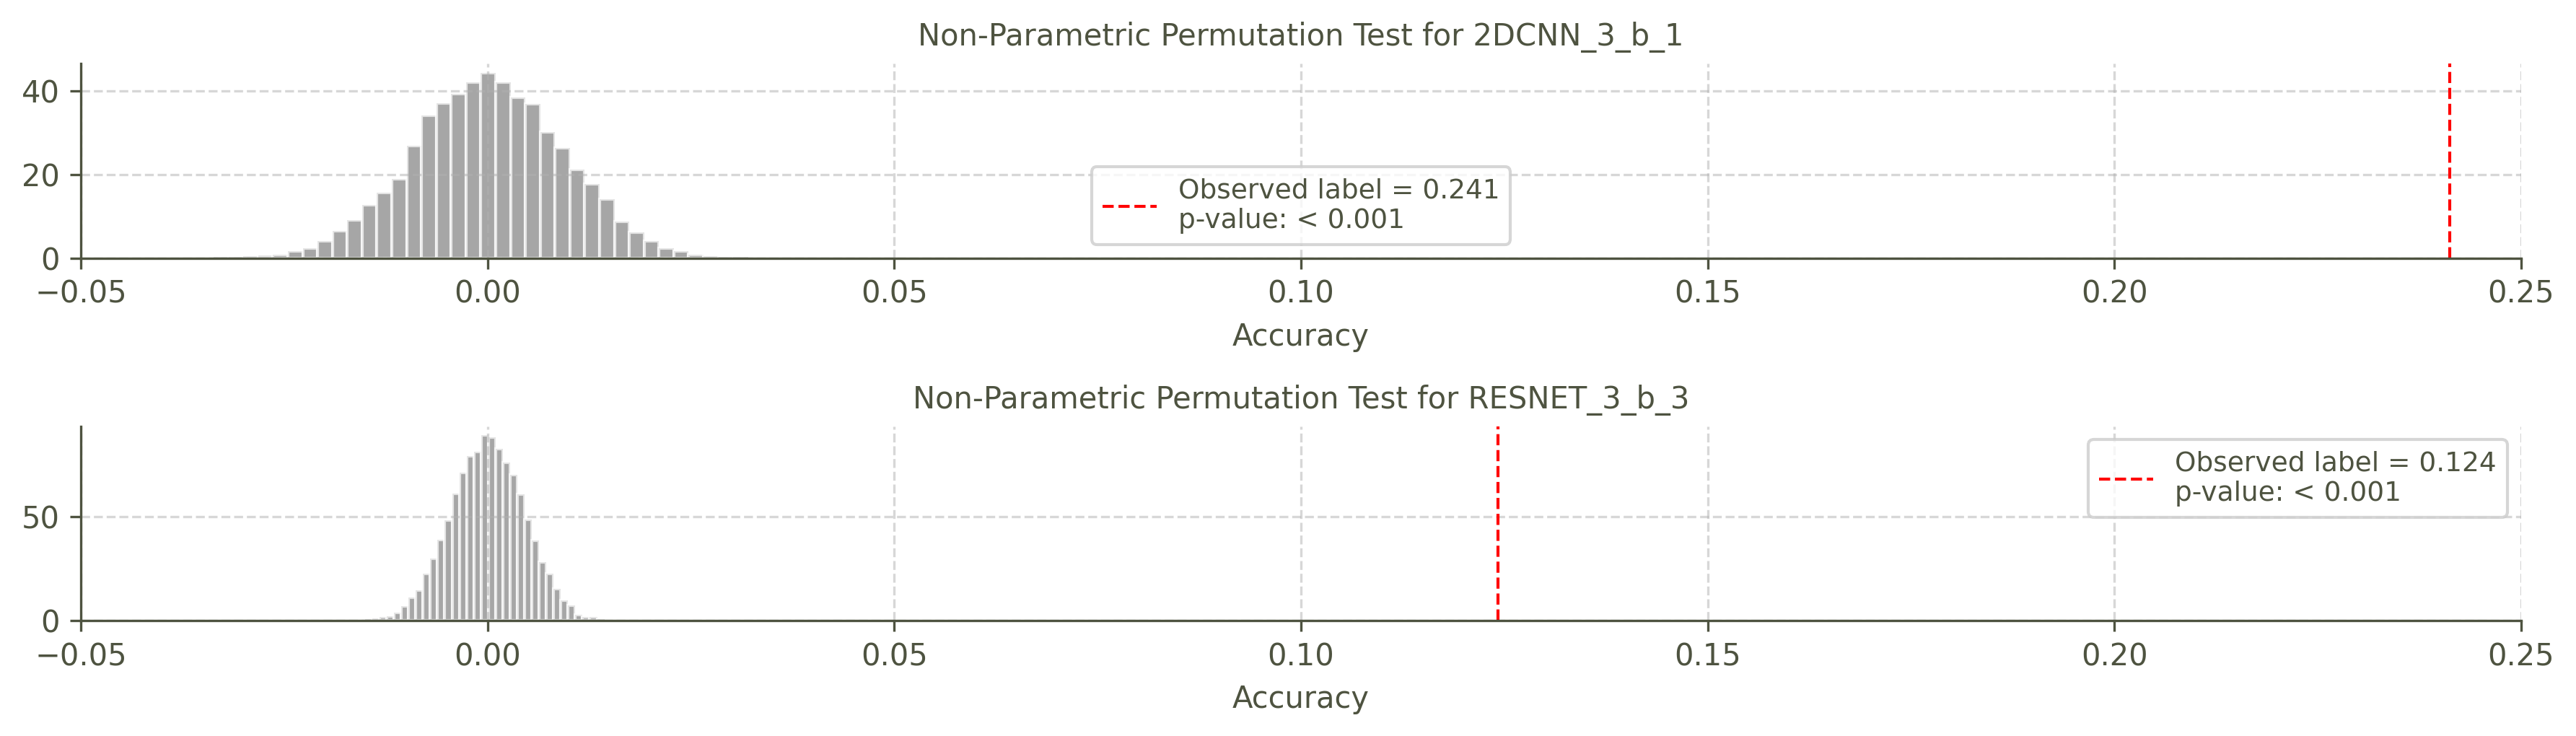

In [30]:
# CREATING VIZ
fig, (ax1, ax2) = plt.subplots(2, 1, 
                               figsize=(12, 3.5),
                               dpi=300,
                              )
axes = {'vanilla2DCNN_v1': ax1, 'RESNET_v1': ax2}  # Map architecture names to axes

#========================================================================================
for gr, d in d_m.groupby(["arch_name"]): 

    #________________________________________________
    # Extract leak and no leak conditions 
    c1 = d["leakage"] == True
    condition1 = d[c1]["acc_tst"].to_numpy()
    condition2 = d[~c1]["acc_tst"].to_numpy()
    cond_arr = np.hstack([condition1, condition2 ])
    
    #________________________________________________
    # Compute observed mean difference
    obs_diff = np.mean(condition1) - np.mean(condition2)
    
    #________________________________________________
    # Performing non-parametric permutations
    n1 = len(condition1)
    null_distribution = []
    for s in range(10000): 
        rng = np.random.default_rng(seed=s)
        rng.shuffle(cond_arr)
        perm_group1 = cond_arr[:n1]
        perm_group2 = cond_arr[n1:]
    
        perm_diff = np.mean(perm_group1) - np.mean(perm_group2)
        null_distribution.append(perm_diff)
    
    #___________
    # Convert to NumPy array
    null_distribution = np.array(null_distribution)
    
    #_______
    # Compute two-sided p-value: 
    #    Checks how often the absolute permuted differences exceed the absolute observed difference.
    p_value = np.mean(np.abs(null_distribution) >= np.abs(obs_diff))
    # print(p_value)

    #========================================================================================
    # PLOT
    ax = axes[gr[0]] 
    ax.hist(null_distribution, bins=40, density=True, 
            alpha=0.7,
            color='gray', edgecolor='white')

    # Add observed difference line
    ax.axvline(obs_diff, color='red', linestyle='--', linewidth=1,
               label=f'Observed label = {obs_diff:.3f}\np-value: < 0.001')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#4E5340')
    ax.spines['bottom'].set_color('#4E5340')
    
    ax.set_xlim(-0.05, 0.25)
    ax.set_xlabel("Accuracy", color="#4E5340")
    
    # For y-axis labels
    for label in ax.get_yticklabels():
        label.set_color('#4E5340')
    # For x-axis labels
    for label in ax.get_xticklabels():
        label.set_color('#4E5340')
    ax.tick_params(color='#4E5340', which='both')
    
    
    ax.legend(fontsize=9,  labelcolor='#4E5340') 

    
    arch_n = "2DCNN_3_b_1" if gr[0] == 'vanilla2DCNN_v1' else "RESNET_3_b_3"
    ax.set_title(f'Non-Parametric Permutation Test for {arch_n}', 
                 fontsize=10, color="#4E5340")

    ax.grid(True, linestyle='--', alpha=0.5)
    
plt.tight_layout()
# plt.savefig("FR_t01e01nb100v1_Permutation_Test_v1.eps", 
#             format='eps', 
#             bbox_inches='tight',
#             dpi=300
#            )
plt.show()

## VIZ Pipe | Arch | Train | Leak |
**Adding pipe performances as training is complete** 

**Sanity check coding**

In [33]:
pipes = []
leaks = []
no_leaks = []
#___________________________________________________________________________
arch_n = "2DCNN"
arch_will_card="vanilla"
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card=arch_will_card, 
                                        pipe_names=['pipe001','pipe002', 'pipe003', 'pipe004'])

metric = "acc_tst"
c1 = d_m["metrics"] == metric
d_ = d_m[c1].reset_index(drop=True)

dct_map = {'splt_strategy_001': 'splt_a', 
           'splt_strategy_002': 'splt_a',
           'splt_strategy_003': 'splt_b',
           'splt_strategy_004': 'splt_b',
          }
d_['splt_strategy'] = d_['split_id'].map(dct_map)

#----------------------------------------------------------------------------

for i, (gr, data) in enumerate(d_.groupby(["pre_pipe_id", "arch_name", "splt_strategy", "trn_strtgy_id"])): 

    mean_metric_leak = data[data["leakage"]==True]["mean"].item()
    mean_metric_no_leak = data[data["leakage"]==False]["mean"].item()

    pipe_n = int(data["pre_pipe_id"].unique().item()[4:])
    splt_n = data["splt_strategy"].unique().item().split("_")[1]
    trn_strategy_n = int(data["trn_strtgy_id"].unique().item().split("_")[-1])

    #____________________________________________________________________
    pipes.append(f"{arch_n}_{pipe_n}_{splt_n}_{trn_strategy_n}")
    leaks.append(mean_metric_leak)
    no_leaks.append(mean_metric_no_leak)
    
    #____________________________________________________________________

In [34]:
#___________________________________________________________________________
arch_n = "RESNET"
arch_will_card="resnet"
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card=arch_will_card, 
                                        pipe_names=['pipe001','pipe002', 'pipe003', 'pipe004'])

metric = "acc_tst"
c1 = d_m["metrics"] == metric
d_ = d_m[c1].reset_index(drop=True)

dct_map = {'splt_strategy_001': 'splt_a', 
           'splt_strategy_002': 'splt_a',
           'splt_strategy_003': 'splt_b',
           'splt_strategy_004': 'splt_b',
          }
d_['splt_strategy'] = d_['split_id'].map(dct_map)

#----------------------------------------------------------------------------

for i, (gr, data) in enumerate(d_.groupby(["pre_pipe_id", "arch_name", "splt_strategy", "trn_strtgy_id"])): 

    try: 
        mean_metric_leak = data[data["leakage"]==True]["mean"].item()
    except Exception: 
        pass
    mean_metric_no_leak = data[data["leakage"]==False]["mean"].item()

    pipe_n = int(data["pre_pipe_id"].unique().item()[4:])
    splt_n = data["splt_strategy"].unique().item().split("_")[1]
    trn_strategy_n = int(data["trn_strtgy_id"].unique().item().split("_")[-1])

    #____________________________________________________________________
    pipes.append(f"{arch_n}_{pipe_n}_{splt_n}_{trn_strategy_n}")
    leaks.append(mean_metric_leak)
    no_leaks.append(mean_metric_no_leak)

In [35]:
#___________________________________________________________________________
arch_n = "ALEXNET"
arch_will_card="alexnet"
d_m = perf_last_epoch_metric_distr_info(d_meta, arch_name_wild_card=arch_will_card, 
                                        pipe_names=['pipe001','pipe002', 'pipe003', 'pipe004'])

metric = "acc_tst"
c1 = d_m["metrics"] == metric
d_ = d_m[c1].reset_index(drop=True)

dct_map = {'splt_strategy_001': 'splt_a', 
           'splt_strategy_002': 'splt_a',
           'splt_strategy_003': 'splt_b',
           'splt_strategy_004': 'splt_b',
          }
d_['splt_strategy'] = d_['split_id'].map(dct_map)

#----------------------------------------------------------------------------

for i, (gr, data) in enumerate(d_.groupby(["pre_pipe_id", "arch_name", "splt_strategy", "trn_strtgy_id"])): 

    mean_metric_leak = data[data["leakage"]==True]["mean"].item()
    mean_metric_no_leak = data[data["leakage"]==False]["mean"].item()

    pipe_n = int(data["pre_pipe_id"].unique().item()[4:])
    splt_n = data["splt_strategy"].unique().item().split("_")[1]
    trn_strategy_n = int(data["trn_strtgy_id"].unique().item().split("_")[-1])

    #____________________________________________________________________
    pipes.append(f"{arch_n}_{pipe_n}_{splt_n}_{trn_strategy_n}")
    leaks.append(mean_metric_leak)
    no_leaks.append(mean_metric_no_leak)

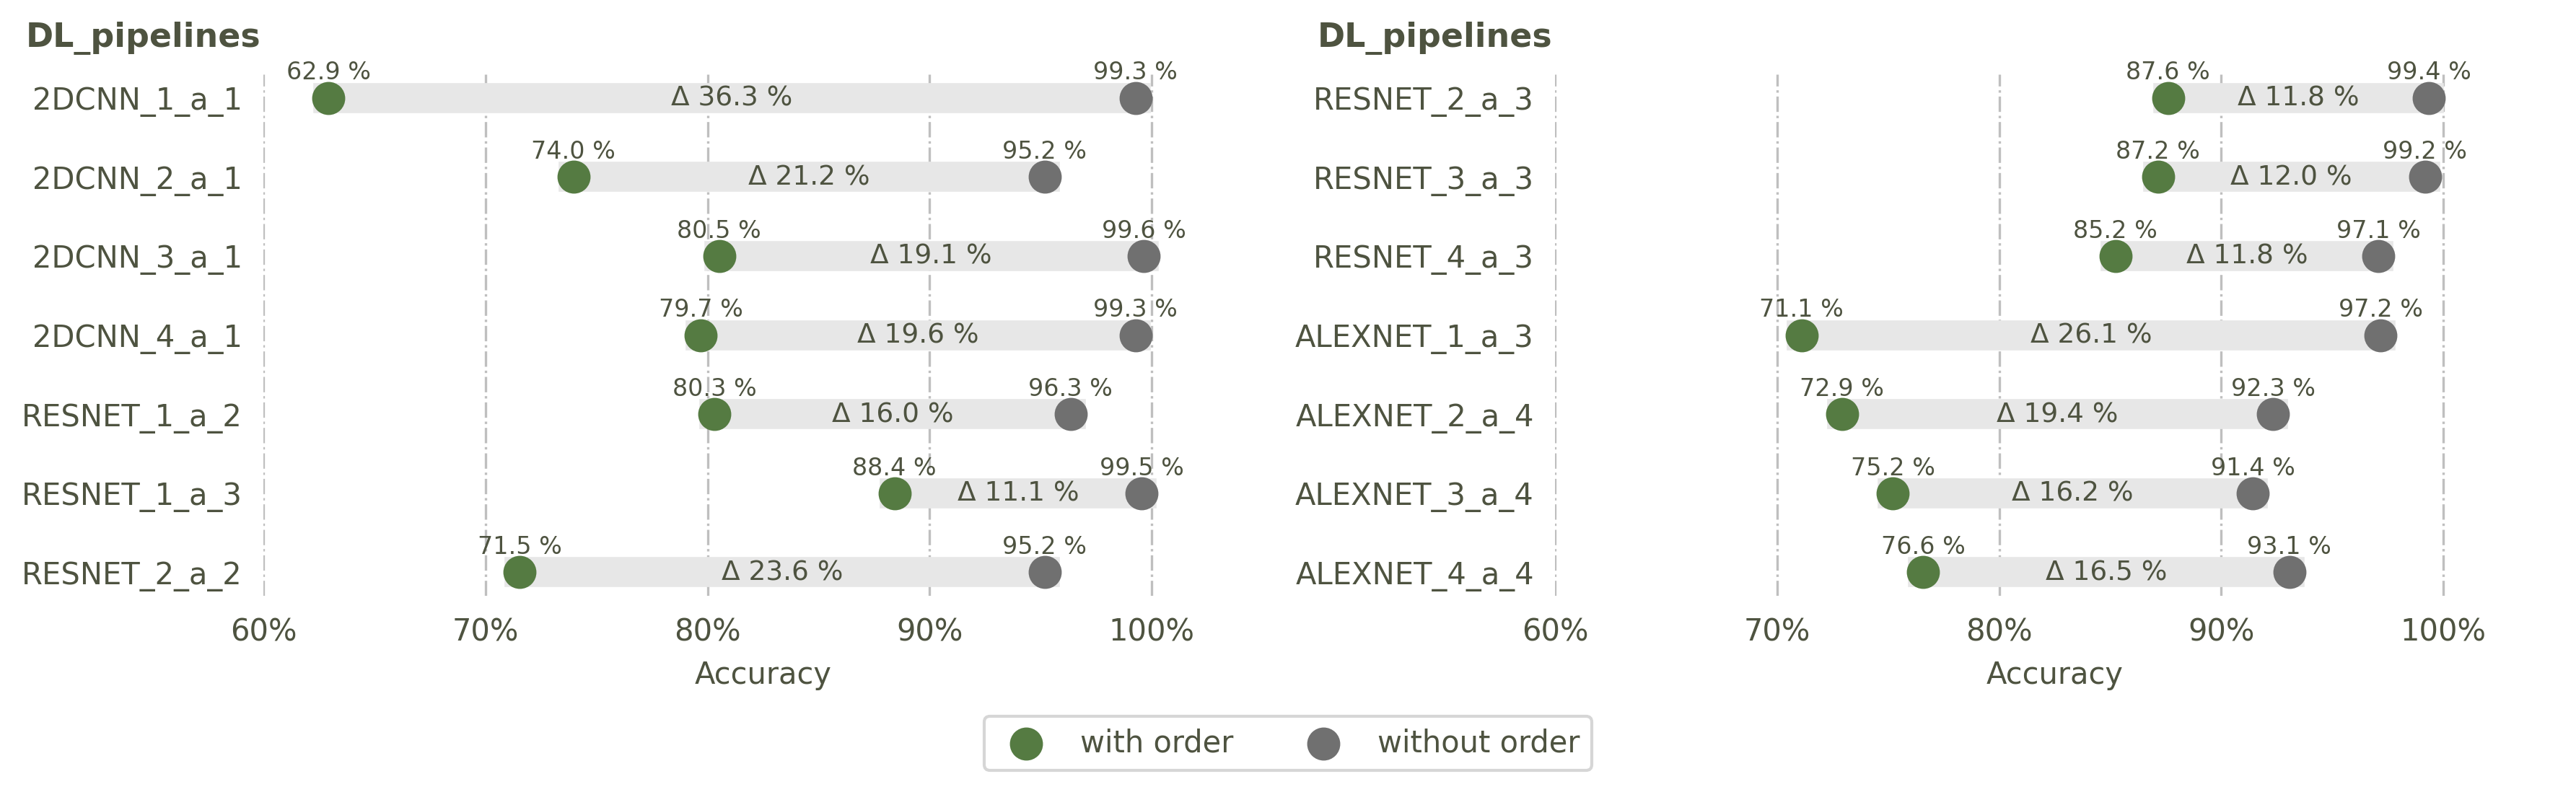

In [38]:
# f"{arch_n}_{pipe_n}_{splt_n}_{trn_strategy_n}" | pipeline name code.
#==========================================================
d1 = pd.DataFrame()
d1["pipes"] = pipes
d1["leaks"] = list(np.array(leaks)*100)
d1["no_leaks"] = list(np.array(no_leaks)*100)

p_n = ["2DCNN_3_b_1", "RESNET_1_a_1", "ALEXNET_1_a_1", "RESNET_3_b_3"] #<<<<<<<<<<<<<<<<<<<<<
c1 = d1["pipes"].isin(p_n)
d1 = d1[~c1].reset_index(drop=True)

#==========================================================
models = d1["pipes"].to_list()
model_a = d1["leaks"].to_list() # Green dots
model_b = d1["no_leaks"].to_list()
deltas = [b - a for a, b in zip(model_a, model_b)]

#==========================================================
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(12, 3.5),
                               dpi=300,
                              )

#______________________________
# LEFT 
#-----------------------------
# Plot lines between points

models = d1["pipes"].to_list()[:7]
model_a = d1["leaks"].to_list()[:7] # Green dots
model_b = d1["no_leaks"].to_list()[:7]
deltas = [b - a for a, b in zip(model_a, model_b)][:7]
y_pos = range(len(models[:7]))


for y, a, b in zip(y_pos, model_a, model_b):
    ax1.plot([a, b], [y, y], color='#E7E7E7', linewidth=10, zorder=3)


# Plot dots
ax1.scatter(model_a, y_pos, 
           color='#707070', #'#2C7FB8', 
           s=100, zorder=3, label="without order",)
ax1.scatter(model_b, y_pos, 
           # color='#B0B0B0', #'#31A354', 
           color='#557B42',
           s=100, zorder=3, label="with order",)

# Add delta labels
for y, a, d in zip(y_pos, model_a, deltas):
    ax1.text(a + d/2, y + 0.17, f"Δ {abs(round(d,1))} %", 
            ha='center', va='bottom', 
            fontsize=9, 
            color="#4E5340",
            # color="#B3B3B3",
            # clip=False,
           )

# Add delta labels <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
for y, a,b, d in zip(y_pos, model_a, model_b, deltas):
    ax1.text(a, y - 0.17, f"{abs(round(a,1))} %", 
            ha='center', va='bottom', 
            fontsize=8, 
            color="#4E5340",
            # color="#B3B3B3",
            # clip=False,
           )
    ax1.text(b, y - 0.17, f"{abs(round(b,1))} %", 
            ha='center', va='bottom', 
            fontsize=8, 
            color="#4E5340",
            # color="#B3B3B3",
            # clip=False,
           )

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Format axes
ax1.set_yticks(y_pos)
ax1.set_yticklabels(models, color="#4E5340")
ax1.annotate(
    "DL_pipelines",
    xy=(0, .98), xycoords='axes fraction',   # Target point at top of y-axis
    xytext=(-40, 10), textcoords='offset points',  # Move left and up
    ha='center', va='bottom',
    fontsize=11, color="#4E5340",
    arrowprops=None, # Or add arrow styling if needed
    fontweight='bold',
)

# # ax.set_ylim(-0.5, 20)
x_ = [#20, 30, 40, 50, 
      60, 70, 80, 90, 100]
ax1.set_xlim(x_[0], x_[-1]+5)
ax1.set_xticks(x_)
ax1.set_xticklabels([f"{x}%" for x in x_],
                   # color="#B3B3B3",
                   color="#4E5340",
                  )
ax1.set_xlabel("Accuracy", color="#4E5340")

ax1.invert_yaxis()  # To match visual order
ax1.grid(axis='x', 
        linestyle='-.', color='gray', alpha=0.5, zorder=-3)
ax1.tick_params(left=False, bottom=False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)


#====================================================
#______________________________
# Right
#-----------------------------
# Plot lines between points

models = d1["pipes"].to_list()[7:]
model_a = d1["leaks"].to_list()[7:] # Green dots
model_b = d1["no_leaks"].to_list()[7:]
deltas = [b - a for a, b in zip(model_a, model_b)]
y_pos = range(len(models))


for y, a, b in zip(y_pos, model_a, model_b):
    ax2.plot([a, b], [y, y], color='#E7E7E7', linewidth=10, zorder=3)


# Plot dots
ax2.scatter(model_a, y_pos, 
           color='#707070', #'#2C7FB8', 
           s=100, zorder=3, label="without order",)
ax2.scatter(model_b, y_pos, 
           # color='#B0B0B0', #'#31A354', 
           color='#557B42',
           s=100, zorder=3, label="with order",)

# Add delta labels
for y, a, d in zip(y_pos, model_a, deltas):
    ax2.text(a + d/2, y + 0.17, f"Δ {abs(round(d,1))} %", 
            ha='center', va='bottom', 
            fontsize=9, 
            color="#4E5340",
            # color="#B3B3B3",
            # clip=False,
           )


# Add delta labels <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
for y, a,b, d in zip(y_pos, model_a, model_b, deltas):
    ax2.text(a, y - 0.17, f"{abs(round(a,1))} %", 
            ha='center', va='bottom', 
            fontsize=8, 
            color="#4E5340",
            # color="#B3B3B3",
            # clip=False,
           )
    ax2.text(b, y - 0.17, f"{abs(round(b,1))} %", 
            ha='center', va='bottom', 
            fontsize=8, 
            color="#4E5340",
            # color="#B3B3B3",
            # clip=False,
           )

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# Format axes
ax2.set_yticks(y_pos)
ax2.set_yticklabels(models, color="#4E5340")
ax2.annotate(
    "DL_pipelines",
    xy=(0, .98), xycoords='axes fraction',   # Target point at top of y-axis
    xytext=(-40, 10), textcoords='offset points',  # Move left and up
    ha='center', va='bottom',
    fontsize=11, color="#4E5340",
    arrowprops=None, # Or add arrow styling if needed
    fontweight='bold',
)

# # ax.set_ylim(-0.5, 20)
x_ = [#20, 30, 40, 50, 
      60, 70, 80, 90, 100]
ax2.set_xlim(x_[0], x_[-1]+5)
ax2.set_xticks(x_)
ax2.set_xticklabels([f"{x}%" for x in x_],
                   # color="#B3B3B3",
                   color="#4E5340",
                  )
ax2.set_xlabel("Accuracy", color="#4E5340")

ax2.invert_yaxis()  # To match visual order
ax2.grid(axis='x', 
        linestyle='-.', color='gray', alpha=0.5, zorder=-3)
ax2.tick_params(left=False, bottom=False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)


#====================================================
# Reverse legend order
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1],  # Reverse
           loc='lower center',
           bbox_to_anchor=(0.5, -0.05),  # (horizontal, vertical) offset
           labelcolor="#4E5340",
           ncol=2,
           # frameon=False,
          )

plt.tight_layout()
plt.subplots_adjust(bottom=0.2) 
# plt.savefig("FR_t01e01nb100v1_Comparison_withoutOrder_withORder_conditions_v1.eps", 
#             format='eps', 
#             bbox_inches='tight',
#             dpi=300
#            )
plt.show() 

In [51]:
d1["delta"] = (d1["leaks"] - d1["no_leaks"]).round(1)
d1

,pipes,leaks,no_leaks,delta
0,2DCNN_1_a_1,99.270233,62.921961,36.3
1,2DCNN_2_a_1,95.167256,73.954007,21.2
2,2DCNN_3_a_1,99.635530,80.514473,19.1
3,2DCNN_4_a_1,99.271059,79.693382,19.6
4,RESNET_1_a_2,96.349511,80.307858,16.0
5,RESNET_1_a_3,99.544205,88.417529,11.1
6,RESNET_2_a_2,95.176347,71.544867,23.6
7,RESNET_2_a_3,99.361557,87.606356,11.8
8,RESNET_3_a_3,99.178909,87.151387,12.0
9,RESNET_4_a_3,97.081758,85.235232,11.8


## Violin Repeated KfoldCV

In [49]:
import matplotlib.colors as mc
def lighten_color(color, factor=0.5):
    """Lightens a hex color by blending it with white (factor=0: no change, 1: white)."""

    color = mc.to_rgb(color)
    return mc.to_hex([(1 - factor) * c + factor for c in color]) 

In [50]:
#-=======================================================
# Selecting performances of repeteated stratified 5KfoldCV
split_ids = ["splt_strategy_003", "splt_strategy_004"]
arch_ids = ["vanilla2DCNN_v1", 'RESNET_v1']
pipe_names = ["pipe003"]
d_m = slctd_folds_perfrms(d_meta=d_meta, split_ids=split_ids, arch_ids=arch_ids, pipe_names=pipe_names)

#-=======================================================
# Extracting ACC for each condition for easy permutation process. 
c1 = d_m["split_id"].isin(['splt_strategy_003'])
c2 = d_m["leakage"].isin([True])
c3 = d_m["arch_name"].isin(['vanilla2DCNN_v1'])
acc_tst_leak_cnn = d_m[c1&c2&c3]["acc_tst"].to_numpy()

c1 = d_m["split_id"].isin(['splt_strategy_004'])
c2 = d_m["leakage"].isin([False])
c3 = d_m["arch_name"].isin(['vanilla2DCNN_v1'])
acc_tst_no_leak_cnn = d_m[c1&c2&c3]["acc_tst"].to_numpy()

c1 = d_m["split_id"].isin(['splt_strategy_003'])
c2 = d_m["leakage"].isin([True])
c3 = d_m["arch_name"].isin(['RESNET_v1'])
acc_tst_leak_resnet = d_m[c1&c2&c3]["acc_tst"].to_numpy()


c1 = d_m["split_id"].isin(['splt_strategy_004'])
c2 = d_m["leakage"].isin([False])
c3 = d_m["arch_name"].isin(['RESNET_v1'])
acc_tst_no_leak_resnet = d_m[c1&c2&c3]["acc_tst"].to_numpy()

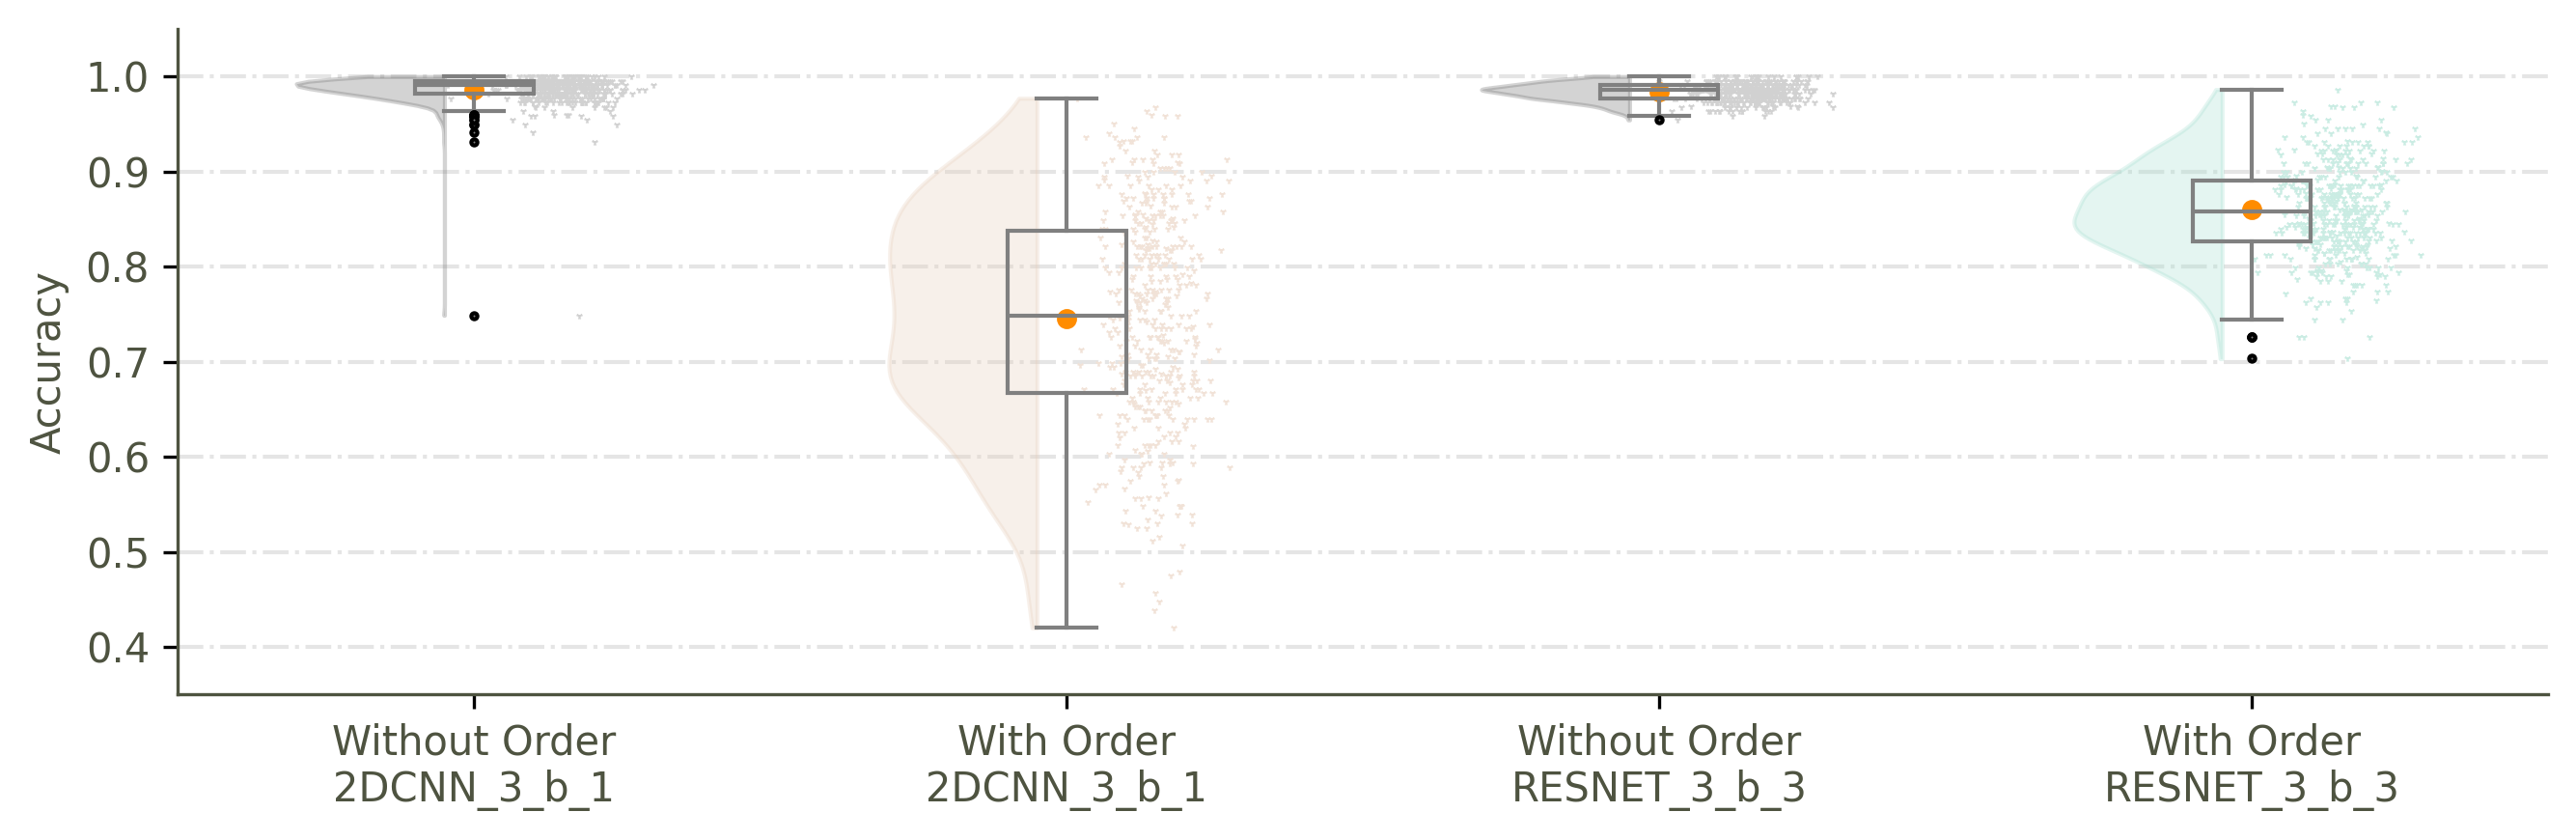

In [51]:
condition1 = list(acc_tst_leak_cnn)
condition2 = list(acc_tst_no_leak_cnn)
condition3 = list(acc_tst_leak_resnet)
condition4 = list(acc_tst_no_leak_resnet)

# Prepare DataFrame for seaborn
data = pd.DataFrame({
    'Score': condition1 + condition2 + condition3 + condition4,
    'Condition': ['Without Order 2DCNN_3_b_1']*len(condition1) + ['With Order 2DCNN_3_b_1']*len(condition2) + ['Without Order RESNET_3_b_3 ']*len(condition1) + ['With Order RESNET_3_b_3 ']*len(condition3)
})

#____________________________________________________
y_data_lst = []
gr_lst = []
for gr, d in data.groupby(["Condition"], sort=False): 
    y_data_lst.append(d.Score.to_list())
    gr_lst.append(gr[0])

    # break


#____________________________________________________
plt.figure(figsize=(9, 3), # (12, 3.5), #
           dpi=300
          )
plt.grid(axis='y', linestyle='-.', color='gray', alpha=0.2, linewidth=1, zorder=-5)

violin_parts = plt.violinplot(y_data_lst,
                              showextrema=False,
                              positions = np.arange(1,5) - 0.05,
                              # showmeans=False,
                              # showmedians=True,
                              side="low", 
                              widths=0.5,
                             )

# Customize colors (one color per violin)
colors = ['#707070', '#E7CFBC', '#707070', '#A6DFD1'] 
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor(color) 
    pc.set_zorder(14.0) 
    # pc.set_alpha(0.4) 


colors_ = ['#CCCCCC', '#E7CFBC', '#CCCCCC', '#A6DFD1'] 
rng = np.random.default_rng(0)
for i, y_data in enumerate(y_data_lst):
    x_jitter = rng.normal(i + 1, 0.05, len(y_data)) + .15  # Add jitter around x=1,2,3
    a = 0.1 if i%2==0 else 0.4
    # print(i, a)
    plt.scatter(x_jitter, y_data, 
                color=lighten_color(colors_[i], factor=a), 
                # alpha=a,
                 marker="2",
                s=0.5,
                zorder=2,
               )

boxplot = plt.boxplot(y_data_lst,
                      widths=0.2,
                      showmeans=False,
                      patch_artist=True,
                      boxprops=dict(facecolor='none', 
                                    edgecolor='gray', 
                                    linewidth=1),  # Box edges
                      whiskerprops=dict(color='gray', 
                                        linewidth=1), # Whisker edges
                      capprops=dict(color='gray', 
                                    linewidth=1), # Cap edges
                      medianprops=dict(color='gray', linewidth=1), # Median line
                      flierprops=dict(marker='.', 
                                      markerfacecolor='gray', 
                                      markersize=3),    # Outliers
                      zorder=14,
                          )
    
# Add mean points (optional)
means = [np.mean(data) for data in y_data_lst]
plt.plot(range(1, len(y_data_lst)+1), means, 
         'o', 
         color='darkorange', 
         label='Mean',
         markersize=4,
         zorder=3,
        )

plt.ylim(.35, 1.05)
x_axis_labels = [f"{' '.join(a.split(' ')[:2])}"  + '\n' f"{''.join(a.split(' ')[2:])}" for a in gr_lst]
plt.xticks(ticks=[1, 2, 3, 4], labels=x_axis_labels, color="#4E5340") 
plt.ylabel("Accuracy", color="#4E5340")
plt.yticks(color="#4E5340") 
ax = plt.gca()  # Get the current Axes object
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#4E5340')
ax.spines['bottom'].set_color('#4E5340')

plt.tight_layout()

# plt.savefig("FR_t01e01nb100v1_repeatedKfoldv1.eps", 
#             format='eps', 
#             bbox_inches='tight',
#             dpi=300
#            )


plt.show()


In [53]:
#=================================================
# Extracting Confidence Interval for expect performance of our DL pipelines 
#  If unseen data for inference has same lung cancer cases spectrum distribution represented in original raw data.

d_lst = []
for gr, d in data.groupby("Condition", sort=False):
    # print(gr)
    d1 = d.describe().T.reset_index(drop=True)
    d1["Condition"] = " ".join(gr.split()[:2])
    d1["DL Pipeline"] = " ".join(gr.split()[2:])
    d1["C.I."] = f"[{np.percentile(d.Score.to_list(), 2.5).round(2):.2f}, {np.percentile(d.Score.to_list(), 97.5).round(2):.2f}]"
    c = ['DL Pipeline', 'Condition', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'C.I.']
    d_lst.append(d1[c].round(4))
dm_RepKfold = pd.concat(d_lst, ignore_index=True)
dm_RepKfold["metric"] = "ACC"
c = ['DL Pipeline', 'Condition', "metric", 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'C.I.']
dm_RepKfold[c]

,DL Pipeline,Condition,metric,mean,std,min,25%,50%,75%,max,C.I.
0,2DCNN_3_b_1,Without Order,ACC,0.9865,0.0145,0.7489,0.9817,0.9909,0.9954,1.0000,"[0.96, 1.00]"
1,2DCNN_3_b_1,With Order,ACC,0.7452,0.1129,0.4201,0.6667,0.7489,0.8379,0.9772,"[0.53, 0.93]"
2,RESNET_3_b_3,Without Order,ACC,0.9840,0.0089,0.9543,0.9772,0.9863,0.9909,1.0000,"[0.96, 1.00]"
3,RESNET_3_b_3,With Order,ACC,0.8598,0.0482,0.7032,0.8265,0.8584,0.8904,0.9863,"[0.77, 0.95]"
